<a href="https://colab.research.google.com/github/SilvanaJ90/usergioarboleda-bootcamp_IA/blob/main/tutorial_redes_neuronales_recurrentes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Redes Neuronales Recurrentes (RNN)


In [ ]:
#Importar los básicos (numpy, os, Pathlib)
import numpy as np
import os
from pathlib import Path

In [ ]:
#Importar Tensorflow y Keras
import tensorflow as tf
from tensorflow import keras

In [ ]:
#Semillas a 42
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
#Matlplotlib
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

## <span style="color:green">1.RNNs Básicas </span>

### <span style="color:blue">1.1 Generando el Dataset</span>

In [ ]:
# Vamos a generar una serie de tiempo básica - primero una función que haga esto
def generate_time_series(batch_size, n_steps):
    freq1,fre1s,offsets1,offsets2, = np.random.rand(4,batch_size,1)
    time = np.linspace(0,1,n_steps)
    series = 0.5 *np.sin((time-offsets1)*(freq1*10+10))
    series += 0.2*np.sin((time-offsets2)*(freq1*10+10))
    series +=0.1 * (np.random.rand(batch_size,n_steps)-0.5)
    return series[...,np.newaxis].astype(np.float32)

In [ ]:
# Ahora vamos a armar nuestra serie de tiempo y romperla en Xtrain, Xvalid y Xtest (y las y's tambien)
n_steps = 50
series = generate_time_series(10000,n_steps+1)

In [ ]:
#Vamos a definir los datos de entrenamiento, de validación y de prueba
X_train, y_train = series[:7000,:n_steps], series[:7000,-1]
X_valid,y_valid = series[7000:9000, :n_steps], series[7000:9000,-1]
X_test,y_test = series[9000:,:n_steps],series[9000:,-1]

In [ ]:
# Revisamos los Shapes de X_train y Y_train
#x_train.shape
y_train.shape

(7000, 1)

In [ ]:
# Copiate del manual una función para plotear las series de tiempo
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$", legend=True):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps,y,"bo", label = "Target")
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "rx", markersize=10, label ="Prediction")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label,fontsize=16)
    if y_label:
        plt.ylabel(y_label,fontsize=16, rotation=0)
    plt.hlines(0,0,100,linewidth=1)
    plt.axis([0, n_steps + 1, -1,1])
    if legend and (y or y_pred):
        plt.legend(fontsize=14, loc = "upper left")


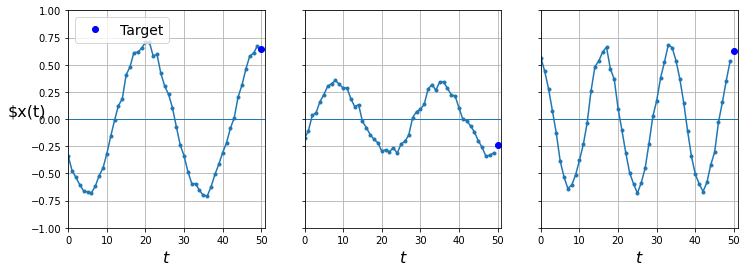

In [ ]:
# Ejecuta tu función para ver las 3 series de tiempo
fig, axes = plt.subplots(nrows = 1, ncols=3, sharey=True, figsize = (12,4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col,:,0],y_valid[col,0],y_label=("$x(t)" if col == 0 else None), legend=(col == 0))

### <span style="color:blue">1.2 Métricas de Línea Base</span>

In [ ]:
#Vamos a hacer predicciones ingenuas
y_pred = X_valid[:,-1]

In [ ]:
#Vamos a ver el error de eso
np.mean(keras.losses.mean_squared_error(y_valid,y_pred))

2022-06-29 16:17:22.870820: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


0.014483721

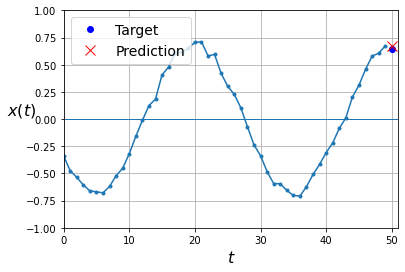

In [ ]:
#Muestra la gráfica con tu predicción
plot_series(X_valid[0,:,0],y_valid[0,0],y_pred[0,0])
plt.show()

In [ ]:
#Vamos ahora a hacer predicciones lineal. Arma tu modelo secuencial con una capa de flatten y dense:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50,1]),
    keras.layers.Dense(1)
])

In [ ]:
#Compila con pérdida MSE y optimizer ADAM
model.compile(loss="mse", optimizer ="adam")

In [ ]:
#Entrena con 20 épocas
history = model.fit(X_train,y_train,epochs=20, validation_data = (X_valid,y_valid))

Epoch 1/20
219/219 [==============================] - 2s 5ms/step - loss: 0.0754 - val_loss: 0.0273
Epoch 2/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0155 - val_loss: 0.0107
Epoch 3/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0090 - val_loss: 0.0082
Epoch 4/20
219/219 [==============================] - 1s 2ms/step - loss: 0.0074 - val_loss: 0.0068
Epoch 5/20
219/219 [==============================] - 1s 2ms/step - loss: 0.0062 - val_loss: 0.0057
Epoch 6/20
219/219 [==============================] - 1s 2ms/step - loss: 0.0051 - val_loss: 0.0048
Epoch 7/20
219/219 [==============================] - 1s 2ms/step - loss: 0.0043 - val_loss: 0.0041
Epoch 8/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0037 - val_loss: 0.0039
Epoch 9/20
219/219 [==============================] - 1s 2ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 10/20
219/219 [==============================] - 1s 2ms/step - loss: 0.0030 - val_loss: 0.0031

In [ ]:
#Evalúa tu modelo sobre valid
model.evaluate(X_valid,y_valid)


63/63 [==============================] - 0s 1ms/step - loss: 0.0022


0.002162977121770382

In [ ]:
#Vamos a armar una gráfica (definir una función) para ver las curvas de aprendizaje
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

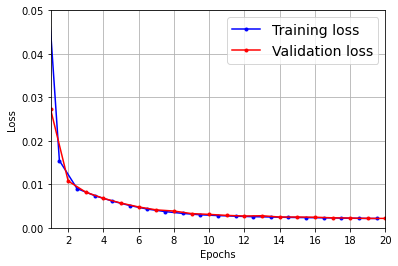

In [ ]:
#Grafica tus curvas de aprendizaje
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

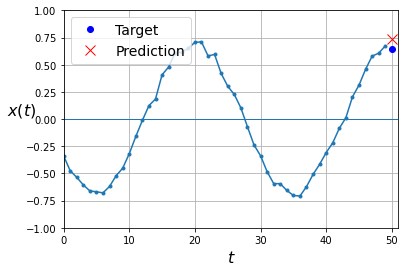

In [ ]:
# Haz una predicción sobre X_valid (con model. predict) y gráficala con tu función de plot series
y_pred = model.predict(X_valid)
plot_series(X_valid[0,:,0],y_valid[0,0],y_pred[0,0])
plt.show()

### <span style="color:blue">1.3 RNN Simple</span>

In [ ]:
#Ármate un modelo de RNN Simple con 1 sola capa y 1 sola neurona
model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape = [None,1])
])

In [ ]:
#Compila con pérdida de MSE y otpimizador ADAM con taza de aprendizaje de 0.005
optimizer = keras.optimizers.Adam(learning_rate=0.005)
model.compile(loss="mse", optimizer = optimizer)

In [ ]:
#Ejecuta tu modelo a 20 épocas
history = model.fit(X_train,y_train,epochs=20, validation_data=(X_valid,y_valid))

Epoch 1/20
219/219 [==============================] - 3s 10ms/step - loss: 0.0304 - val_loss: 0.0104
Epoch 2/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0094 - val_loss: 0.0088
Epoch 3/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0092 - val_loss: 0.0087
Epoch 4/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0091 - val_loss: 0.0087
Epoch 5/20
219/219 [==============================] - 3s 14ms/step - loss: 0.0091 - val_loss: 0.0086
Epoch 6/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0091 - val_loss: 0.0086
Epoch 7/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0091 - val_loss: 0.0087
Epoch 8/20
219/219 [==============================] - 3s 14ms/step - loss: 0.0091 - val_loss: 0.0087
Epoch 9/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0091 - val_loss: 0.0086
Epoch 10/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0091 - val_los

In [ ]:
#Evalúa el modelo con Xvalid
model.evaluate(X_valid,y_valid)

63/63 [==============================] - 0s 4ms/step - loss: 0.0086


0.008640117943286896

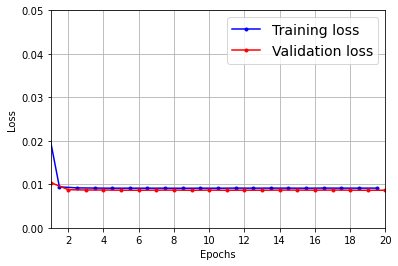

In [ ]:
#Grafica la curva de aprendizaje
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

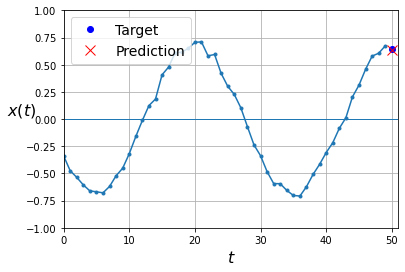

In [ ]:
#Grafica la prediccion vs target
y_pred = model.predict(X_valid)
plot_series(X_valid[0,:,0],y_valid[0,0],y_pred[0,0])
plt.show()

### <span style="color:blue">1.4 RNN Profundo</span>

In [ ]:
#Arma un modelo de RNN profundo con 3 capas - 20 neuronas por capa y la tercera 1 neurona de salida
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None,1]),
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None,1]),
    keras.layers.SimpleRNN(1)
])

In [ ]:
#Comipla con pérdida MSE, Optimizador Adam
model.compile(loss = "mse", optimizer = "adam")

In [ ]:
#Ejecuta a 20 épocas
history = model.fit(X_train,y_train, epochs = 20, validation_data = (X_valid,y_valid))

Epoch 1/20
219/219 [==============================] - 14s 45ms/step - loss: 0.0144 - val_loss: 0.0031
Epoch 2/20
219/219 [==============================] - 10s 44ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 3/20
219/219 [==============================] - 7s 33ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 4/20
219/219 [==============================] - 7s 32ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 5/20
219/219 [==============================] - 8s 36ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 6/20
219/219 [==============================] - 7s 34ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 7/20
219/219 [==============================] - 8s 34ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 8/20
219/219 [==============================] - 8s 37ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 9/20
219/219 [==============================] - 7s 31ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 10/20
219/219 [==============================] - 7s 30ms/step - loss: 0.0016 - val_

In [ ]:
#Evalúa tu modelo
model.evaluate(X_valid,y_valid)

63/63 [==============================] - 1s 11ms/step - loss: 0.0014


0.0014484303537756205

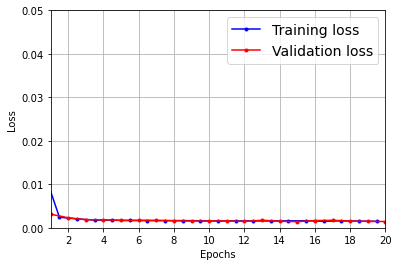

In [ ]:
#Curvas de Aprendizaje
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

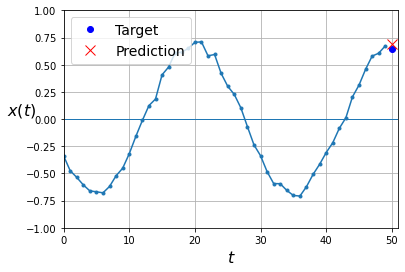

In [ ]:
#Gráfica de target vs Aprendizaje
y_pred= model.predict(X_valid)
plot_series(X_valid[0,:,0], y_valid[0,0],y_pred[0,0])
plt.show()

In [ ]:
# Vamos a rearmar nuestro modelo profundo pero para que la segunda capa de SimpleRNN devuelva solo la última salida
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20,return_sequences = True, input_shape=[None,1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])

In [ ]:
# Compila MSE, ADAM
model.compile(loss="mse", optimizer="adam")

In [ ]:
# Ejecuta, 20 épocas
history = model.fit(X_train,y_train, epochs=20, validation_data=(X_valid,y_valid))

Epoch 1/20
219/219 [==============================] - 8s 28ms/step - loss: 0.0701 - val_loss: 0.0079
Epoch 2/20
219/219 [==============================] - 6s 25ms/step - loss: 0.0053 - val_loss: 0.0033
Epoch 3/20
219/219 [==============================] - 6s 27ms/step - loss: 0.0028 - val_loss: 0.0022
Epoch 4/20
219/219 [==============================] - 6s 28ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 5/20
219/219 [==============================] - 6s 26ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 6/20
219/219 [==============================] - 6s 25ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 7/20
219/219 [==============================] - 7s 30ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 8/20
219/219 [==============================] - 7s 31ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 9/20
219/219 [==============================] - 9s 42ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 10/20
219/219 [==============================] - 7s 31ms/step - loss: 0.0016 - val_lo

In [ ]:
# Evalúa
model.evaluate(X_valid,y_valid)

63/63 [==============================] - 0s 7ms/step - loss: 0.0015


0.0015201137866824865

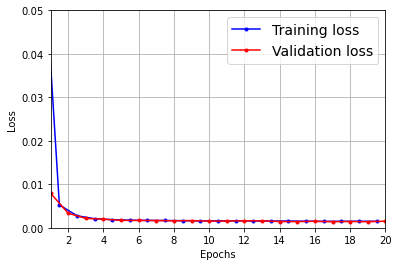

In [ ]:
#Curvas de Aprendizaje
plot_learning_curves(history.history["loss"],history.history["val_loss"])

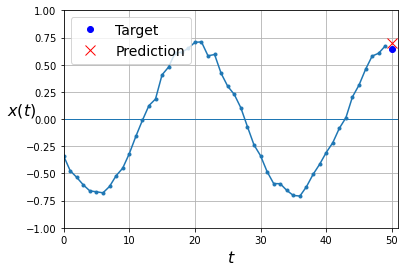

In [ ]:
# Target vs Predicción
y_pred = model.predict(X_valid)
plot_series(X_valid[0,:,0], y_valid[0,0], y_pred[0,0])
plt.show()

### <span style="color:blue">1.5 Predecir Varios Pasos Adelante</span>

In [ ]:
#Semillas a 40
np.random.seed(40)

In [ ]:
#Genera una nueva serie de tiempo
series = generate_time_series(1,n_steps+10)
X_new, Y_new = series[:,:n_steps], series[:,n_steps:]
X = X_new
for step_ahead in range(10):
    y_pred_one = model.predict(X[:,step_ahead:])[:,np.newaxis,:]
    X=np.concatenate([X,y_pred_one],axis = 1)

Y_pred = X[:,n_steps:]

In [ ]:
#Saca la figura de tu serie de tiempo
Y_pred.shape

(1, 10, 1)

In [ ]:
#Arma una nueva función para graficar varias predicciones
def plot_multiple_forecasts(X,Y,Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0,:,0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0,:,0], "bo-", label = "Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0,:,0], "rx-", label ="Forecast", markersize=10)
    plt.axis([0,n_steps + ahead, -1, 1])
    plt.legend(fontsize = 14)

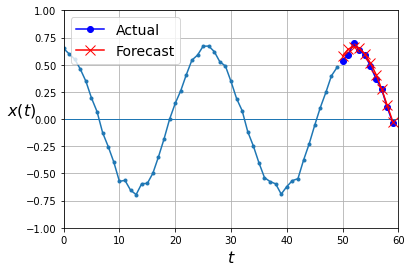

In [ ]:
#Prueba tu nueva gráfica
plot_multiple_forecasts(X_new,Y_new,Y_pred)
plt.show()

In [ ]:
#Semillas a 40
np.random.seed(42)

In [ ]:
#Genera una nueva serie de tiempo con la función nueva
n_steps = 50
series = generate_time_series(10000,n_steps + 10)

In [ ]:
#Guarda tus datos en X_train, Y_train, X_test
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

In [ ]:
#Vamos a predecir los siguientes 10 valores uno por uno
X = X_valid
for step_ahead in range(10):
    y_pred_one = model.predict(X)[:,np.newaxis,:]
    X = np.concatenate([X,y_pred_one], axis = 1)

Y_pred = X[:,n_steps:,0]

In [ ]:
#Figura de tu predicción
Y_pred.shape

(2000, 10)

In [ ]:
#Saca el promedio de los erroes cuadrados
np.mean(keras.metrics.mean_squared_error(Y_valid,Y_pred))

0.008652486

### <span style="color:blue">1.6 Comparemos nuestro desempeño con predicciones ingenuas de un modelo simple lineal</span>

In [ ]:
#Toma el valor del último paso de tiempo y repitlo 10 veces
Y_naive_pred = np.tile(X_valid[:,-1],10)

In [ ]:
Y_naive_pred

array([[-0.13713104, -0.13713104, -0.13713104, ..., -0.13713104,
        -0.13713104, -0.13713104],
       [ 0.01940748,  0.01940748,  0.01940748, ...,  0.01940748,
         0.01940748,  0.01940748],
       [-0.6801544 , -0.6801544 , -0.6801544 , ..., -0.6801544 ,
        -0.6801544 , -0.6801544 ],
       ...,
       [ 0.3898151 ,  0.3898151 ,  0.3898151 , ...,  0.3898151 ,
         0.3898151 ,  0.3898151 ],
       [ 0.31291625,  0.31291625,  0.31291625, ...,  0.31291625,
         0.31291625,  0.31291625],
       [-0.4083407 , -0.4083407 , -0.4083407 , ..., -0.4083407 ,
        -0.4083407 , -0.4083407 ]], dtype=float32)

In [ ]:
#promedio de error cuadrado
np.mean(keras.metrics.mean_squared_error(Y_valid,Y_naive_pred))

0.2447

In [ ]:
#Arma un modelo secuencial sencillo con una capa flatten y una capa densa de 10
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50,1]),
    keras.layers.Dense(10)
])

In [ ]:
# Compila con MSE y ADAM, ejecuta a 20 epocas
model.compile(loss="mse",optimizer="adam")
history=model.fit(X_train,Y_train, epochs = 20, validation_data = (X_valid,Y_valid))

Epoch 1/20
219/219 [==============================] - 2s 5ms/step - loss: 0.0894 - val_loss: 0.0263
Epoch 2/20
219/219 [==============================] - 1s 2ms/step - loss: 0.0196 - val_loss: 0.0141
Epoch 3/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0128 - val_loss: 0.0107
Epoch 4/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0106 - val_loss: 0.0096
Epoch 5/20
219/219 [==============================] - 1s 2ms/step - loss: 0.0097 - val_loss: 0.0088
Epoch 6/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0090 - val_loss: 0.0084
Epoch 7/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0084 - val_loss: 0.0078
Epoch 8/20
219/219 [==============================] - 1s 2ms/step - loss: 0.0079 - val_loss: 0.0074
Epoch 9/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0075 - val_loss: 0.0069
Epoch 10/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0071 - val_loss: 0.0066

In [ ]:
# Ahora creamos un RNN que predice todos los siguientes 10 valores al mismo tiempo
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)
])

In [ ]:
#Compila con MSE, optimizador NADAM
model.compile(loss="mse", optimizer = "adam")

In [ ]:
#Ejecuta a 20 épocas
history = model.fit(X_train,Y_train, epochs = 20, validation_data = (X_valid,Y_valid))

Epoch 1/20
219/219 [==============================] - 8s 29ms/step - loss: 0.0339 - val_loss: 0.0107
Epoch 2/20
219/219 [==============================] - 7s 30ms/step - loss: 0.0083 - val_loss: 0.0062
Epoch 3/20
219/219 [==============================] - 6s 27ms/step - loss: 0.0060 - val_loss: 0.0059
Epoch 4/20
219/219 [==============================] - 7s 30ms/step - loss: 0.0049 - val_loss: 0.0043
Epoch 5/20
219/219 [==============================] - 6s 26ms/step - loss: 0.0044 - val_loss: 0.0040
Epoch 6/20
219/219 [==============================] - 5s 23ms/step - loss: 0.0037 - val_loss: 0.0046
Epoch 7/20
219/219 [==============================] - 6s 27ms/step - loss: 0.0034 - val_loss: 0.0034
Epoch 8/20
219/219 [==============================] - 6s 26ms/step - loss: 0.0030 - val_loss: 0.0027
Epoch 9/20
219/219 [==============================] - 6s 26ms/step - loss: 0.0029 - val_loss: 0.0027
Epoch 10/20
219/219 [==============================] - 5s 24ms/step - loss: 0.0025 - val_lo

In [ ]:
#Genera una nueva serie de tiempo, asignasela a xnew y ynew, usaloas para hace runa prediccion ypred
np.random.seed(43)

series = generate_time_series(1, 50+10)
X_new, Y_new = series[:,:50,:], series[:,-10:,:]
Y_pred = model.predict(X_new)[...,np.newaxis]

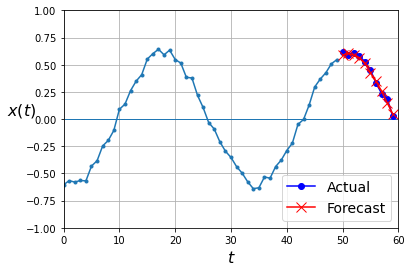

In [ ]:
#Grafica tus forecasts multiples
plot_multiple_forecasts(X_new,Y_new,Y_pred)
plt.show()

In [ ]:
Y_pred-Y_new

array([[[-0.02507842],
        [ 0.01174527],
        [-0.02365482],
        [-0.01887631],
        [-0.00976056],
        [-0.02467674],
        [ 0.01505408],
        [ 0.02145098],
        [-0.03821154],
        [ 0.02142729]]], dtype=float32)

### <span style="color:blue">1.7 Creamos un modelo que predice los siguientes 10 pasos a a cada paso</span>


In [ ]:
#Generamos nuestra serie de tiempo
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)

In [ ]:
#Asignamos a xtrain, xvalid y x test
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]

In [ ]:
#Asignamos a ytrain, yvalid, y ytest
Y = np.empty((10000,n_steps,10))

In [ ]:
#Como va a funcionar le modelo
for step_ahead in range(1,10+1):
    Y[...,step_ahead-1] = series[...,step_ahead:step_ahead+n_steps,0]

In [ ]:
 Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [ ]:
#Figura de tu modelo
Y_train.shape

(7000, 50, 10)

In [ ]:
#Armamos nuestro RNN
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

In [ ]:
#Define una función de útlimo paso
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

In [ ]:
# Compila con MSE, ADAM
model.compile(loss = "mse", optimizer = keras.optimizers.Adam(learning_rate=0.01), metrics = [last_time_step_mse])
history = model.fit(X_train, Y_train, epochs = 20, validation_data=(X_valid,Y_valid))

Epoch 1/20
219/219 [==============================] - 8s 24ms/step - loss: 0.0334 - last_time_step_mse: 0.0242 - val_loss: 0.0204 - val_last_time_step_mse: 0.0095
Epoch 2/20
219/219 [==============================] - 6s 27ms/step - loss: 0.0196 - last_time_step_mse: 0.0092 - val_loss: 0.0184 - val_last_time_step_mse: 0.0091
Epoch 3/20
219/219 [==============================] - 6s 29ms/step - loss: 0.0152 - last_time_step_mse: 0.0065 - val_loss: 0.0139 - val_last_time_step_mse: 0.0063
Epoch 4/20
219/219 [==============================] - 8s 37ms/step - loss: 0.0128 - last_time_step_mse: 0.0056 - val_loss: 0.0116 - val_last_time_step_mse: 0.0054
Epoch 5/20
219/219 [==============================] - 9s 39ms/step - loss: 0.0111 - last_time_step_mse: 0.0049 - val_loss: 0.0101 - val_last_time_step_mse: 0.0043
Epoch 6/20
219/219 [==============================] - 7s 30ms/step - loss: 0.0106 - last_time_step_mse: 0.0047 - val_loss: 0.0096 - val_last_time_step_mse: 0.0040
Epoch 7/20
219/219 [==

In [ ]:
#Ejecuta tu modelo a 20 épocas

In [ ]:
#Genera tu serie de Tiempo

In [ ]:
#Asígnala a XNew YNew, haz tu YPRED

In [ ]:
#Grafica tus múltiples forecasts

## <span style="color:green">2. Manejando Secuencias largas </span>

### <span style="color:blue">2.1 RNN Profundos con Batch Norm </span>


In [ ]:
#Arma un modelo con 2 capas de RNN, seguidas cada una de batchnorm, terminas con una Dense time distributed
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20,return_sequences = True, input_shape = [None,1]),
    keras.layers.BatchNormalization(),
    keras.layers.SimpleRNN(20, return_sequences = True),
    keras.layers.BatchNormalization(),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

In [ ]:
#Compila con MSE, NADAM
model.compile(loss = "mse", optimizer = "adam", metrics = [last_time_step_mse])

In [ ]:
#Ejecuta a 20 épocas sobre tu XTrain y Ytrain
history = model.fit(X_train, Y_train, epochs = 20, validation_data = (X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 8s 25ms/step - loss: 0.1225 - last_time_step_mse: 0.1105 - val_loss: 0.1182 - val_last_time_step_mse: 0.1128
Epoch 2/20
219/219 [==============================] - 5s 23ms/step - loss: 0.0301 - last_time_step_mse: 0.0210 - val_loss: 0.0469 - val_last_time_step_mse: 0.0377
Epoch 3/20
219/219 [==============================] - 6s 28ms/step - loss: 0.0229 - last_time_step_mse: 0.0143 - val_loss: 0.0212 - val_last_time_step_mse: 0.0126
Epoch 4/20
219/219 [==============================] - 6s 29ms/step - loss: 0.0192 - last_time_step_mse: 0.0111 - val_loss: 0.0172 - val_last_time_step_mse: 0.0091
Epoch 5/20
219/219 [==============================] - 6s 27ms/step - loss: 0.0170 - last_time_step_mse: 0.0093 - val_loss: 0.0154 - val_last_time_step_mse: 0.0077
Epoch 6/20
219/219 [==============================] - 6s 27ms/step - loss: 0.0155 - last_time_step_mse: 0.0078 - val_loss: 0.0153 - val_last_time_step_mse: 0.0081
Epoch 7/20
219/219 [==

### <span style="color:blue">2.2 RNN Profundos con Layer Norm </span>

In [ ]:
#Importa LayerNormalization de keras.layers
from tensorflow.keras.layers import LayerNormalization

In [ ]:
#Crea una clase que se llama LNSimpleRNNCELL
class LNSimpleRNNCell(keras.layers.Layer):
    def __init__(self, units, activation = "tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = keras.layers.SimpleRNNCell(units, activation = None)
        self.layer_norm = LayerNormalization()
        self.activation = keras.activations.get(activation)
    def get_initial_state(self,inputs = None, batch_size = None, dtype=None):
        if inputs is not None:
            batch_size = tf.shape(inputs)[0]
            dtype = inptus.dtype
        return [tf.zeros([batch_size, self.state_size], dtype=dtype)]
    def call(self,inputs,states):
        outputs, new_states = self.simple_rnn_cell(inputs,states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

In [ ]:
#Crea un modelo secuencial de RNN con 2 de estas nuevas capas, y un time distributed Dense
model = keras.models.Sequential([
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True, input_shape=[None, 1]),
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

In [ ]:
#>Compila a MSE y ADAM
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])

In [ ]:
#History Model.Fit a 20 epocas
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 16s 56ms/step - loss: 0.1397 - last_time_step_mse: 0.1276 - val_loss: 0.0478 - val_last_time_step_mse: 0.0360
Epoch 2/20
219/219 [==============================] - 12s 53ms/step - loss: 0.0416 - last_time_step_mse: 0.0300 - val_loss: 0.0351 - val_last_time_step_mse: 0.0240
Epoch 3/20
219/219 [==============================] - 11s 52ms/step - loss: 0.0320 - last_time_step_mse: 0.0205 - val_loss: 0.0277 - val_last_time_step_mse: 0.0158
Epoch 4/20
219/219 [==============================] - 12s 54ms/step - loss: 0.0253 - last_time_step_mse: 0.0135 - val_loss: 0.0226 - val_last_time_step_mse: 0.0106
Epoch 5/20
219/219 [==============================] - 10s 46ms/step - loss: 0.0216 - last_time_step_mse: 0.0099 - val_loss: 0.0200 - val_last_time_step_mse: 0.0092
Epoch 6/20
219/219 [==============================] - 11s 52ms/step - loss: 0.0189 - last_time_step_mse: 0.0078 - val_loss: 0.0174 - val_last_time_step_mse: 0.0069
Epoch 7/20
219/2

### <span style="color:blue">2.3 LSTM (Long Short Term-Memory) </span>

In [ ]:
#Arma un modelo con 2 LSTMS y un Dense time Dsitributed
model = keras.models.Sequential([
    keras.layers.LSTM(20,return_sequences=True, input_shape=[None,1]),
    keras.layers.LSTM(20,return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

In [ ]:
#Compila con MSE y ADAM
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])

In [ ]:
#Ejecuta a 20 épocas
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 19s 65ms/step - loss: 0.0604 - last_time_step_mse: 0.0429 - val_loss: 0.0312 - val_last_time_step_mse: 0.0091
Epoch 2/20
219/219 [==============================] - 11s 49ms/step - loss: 0.0278 - last_time_step_mse: 0.0074 - val_loss: 0.0244 - val_last_time_step_mse: 0.0053
Epoch 3/20
219/219 [==============================] - 14s 63ms/step - loss: 0.0231 - last_time_step_mse: 0.0052 - val_loss: 0.0212 - val_last_time_step_mse: 0.0044
Epoch 4/20
219/219 [==============================] - 11s 52ms/step - loss: 0.0203 - last_time_step_mse: 0.0041 - val_loss: 0.0188 - val_last_time_step_mse: 0.0033
Epoch 5/20
219/219 [==============================] - 12s 54ms/step - loss: 0.0184 - last_time_step_mse: 0.0033 - val_loss: 0.0172 - val_last_time_step_mse: 0.0028
Epoch 6/20
219/219 [==============================] - 11s 51ms/step - loss: 0.0171 - last_time_step_mse: 0.0029 - val_loss: 0.0161 - val_last_time_step_mse: 0.0027
Epoch 7/20
219/2

In [ ]:
#Evalúa
model.evaluate(X_valid, Y_valid)

63/63 [==============================] - 1s 10ms/step - loss: 0.0092 - last_time_step_mse: 0.0022


[0.009187659248709679, 0.0022120901849120855]

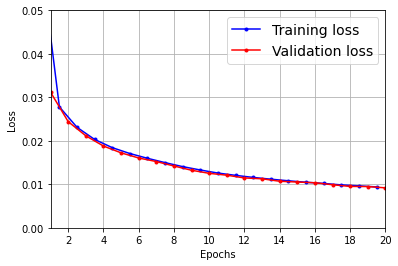

In [ ]:
#Grafica las curvas de Aprendizaje
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [ ]:
#Arma tu esquema de generar series de tiempo, crear xnew y ynew, y probar con model.predict
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

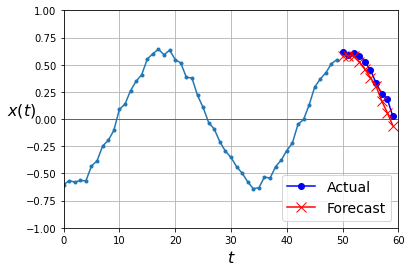

In [ ]:
#Grafica tus forecasts múltiples
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

### <span style="color:blue">2.4 GRU (Gated Recurrent Unit) </span>

In [ ]:
#Arma un modelo con 2 GRUs y un Dense time Distributed
model = keras.models.Sequential([
    keras.layers.GRU(20, return_sequences=True, input_shape=[None,1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

In [ ]:
#Compila con MSE y ADAM
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])

In [ ]:
#Ejecuta a 20 épocas
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 15s 48ms/step - loss: 0.0575 - last_time_step_mse: 0.0502 - val_loss: 0.0317 - val_last_time_step_mse: 0.0236
Epoch 2/20
219/219 [==============================] - 11s 49ms/step - loss: 0.0277 - last_time_step_mse: 0.0182 - val_loss: 0.0235 - val_last_time_step_mse: 0.0139
Epoch 3/20
219/219 [==============================] - 11s 50ms/step - loss: 0.0215 - last_time_step_mse: 0.0115 - val_loss: 0.0187 - val_last_time_step_mse: 0.0086
Epoch 4/20
219/219 [==============================] - 12s 53ms/step - loss: 0.0165 - last_time_step_mse: 0.0070 - val_loss: 0.0146 - val_last_time_step_mse: 0.0059
Epoch 5/20
219/219 [==============================] - 14s 64ms/step - loss: 0.0144 - last_time_step_mse: 0.0058 - val_loss: 0.0134 - val_last_time_step_mse: 0.0051
Epoch 6/20
219/219 [==============================] - 11s 50ms/step - loss: 0.0133 - last_time_step_mse: 0.0051 - val_loss: 0.0125 - val_last_time_step_mse: 0.0045
Epoch 7/20
219/2

In [ ]:
#Evalúa

In [ ]:
#Grafica las curvas de Aprendizaje

In [ ]:
#Arma tu esquema de generar series de tiempo, crear xnew y ynew, y probar con model.predict

In [ ]:
#Grafica tus forecasts multiples

### <span style="color:blue">2.5 Capas Convolucionales para procesar Secuencias </span>


In [ ]:
model = keras.models.Sequential([
    keras.layers.Conv1D(filters = 20, kernel_size = 4, strides = 2, padding = "valid", input_shape=[None,1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

In [ ]:
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train[:, 3::2], epochs=20,
                    validation_data=(X_valid, Y_valid[:, 3::2]))

Epoch 1/20
219/219 [==============================] - 13s 36ms/step - loss: 0.0483 - last_time_step_mse: 0.0410 - val_loss: 0.0226 - val_last_time_step_mse: 0.0149
Epoch 2/20
219/219 [==============================] - 6s 28ms/step - loss: 0.0163 - last_time_step_mse: 0.0104 - val_loss: 0.0120 - val_last_time_step_mse: 0.0066
Epoch 3/20
219/219 [==============================] - 6s 28ms/step - loss: 0.0115 - last_time_step_mse: 0.0065 - val_loss: 0.0104 - val_last_time_step_mse: 0.0055
Epoch 4/20
219/219 [==============================] - 7s 32ms/step - loss: 0.0099 - last_time_step_mse: 0.0051 - val_loss: 0.0089 - val_last_time_step_mse: 0.0043
Epoch 5/20
219/219 [==============================] - 6s 27ms/step - loss: 0.0086 - last_time_step_mse: 0.0040 - val_loss: 0.0080 - val_last_time_step_mse: 0.0034
Epoch 6/20
219/219 [==============================] - 8s 35ms/step - loss: 0.0077 - last_time_step_mse: 0.0033 - val_loss: 0.0072 - val_last_time_step_mse: 0.0030
Epoch 7/20
219/219 [=